## Climate indicator comparisons

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
import matplotlib.lines as mlines

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
1,1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
2,2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
3,3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
4,4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722329,1722329,1722329,1805040,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722330,1722330,1722330,1805041,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722331,1722331,1722331,1805042,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0
1722332,1722332,1722332,1805043,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0


In [3]:
pd.unique(obs['current'])

array(['shelf', nan, 'CUC', 'CC'], dtype=object)

In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [5]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

/tmp/ipykernel_2401109/497193821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['dist'] = obs_cuc.NSdist
/tmp/ipykernel_2401109/497193821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf['dist'] = obs_shelf.NSdist
/tmp/ipykernel_2401109/497193821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

In [6]:
def add_time(df, year_col="year", month_col="month"):
    df = df.copy()
    df["day"] = 1
    df["time"] = pd.to_datetime(df[[year_col, month_col, "day"]])
    return df

def add_decimal_year(df, year_col="year", time_col="time"):
    df = df.copy()
    start_of_year = pd.to_datetime(df[year_col].astype(str) + "-01-01")
    end_of_year   = pd.to_datetime((df[year_col] + 1).astype(str) + "-01-01")
    df["decimal_yr"] = df[year_col] + (df[time_col] - start_of_year) / (end_of_year - start_of_year)
    return df

def add_running_mean_12m(df, index_col="index", time_col="time",
                         center=True, min_periods=12, out_col="index_rm12"):
    """
    12-month running mean on a monthly series.
    center=True -> centered window (recommended if you want a pure low-pass feel)
    min_periods=12 -> require a full 12 months for a value
    """
    df = df.sort_values(time_col).reset_index(drop=True).copy()
    df[out_col] = (
        df[index_col]
        .rolling(window=12, center=center, min_periods=min_periods)
        .mean()
    )
    return df


# -------------------------
# ENSO (wide -> long -> monthly rm12)
# -------------------------
enso = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/enso1979.csv",
    names=["year"] + [str(x + 1) for x in range(12)]
)

enso = enso.melt(id_vars="year", var_name="month", value_name="index")
enso["month"] = enso["month"].astype(int)
enso = enso.sort_values(["year", "month"]).reset_index(drop=True)

enso = add_time(enso)
enso = add_decimal_year(enso)
enso = add_running_mean_12m(enso, index_col="index", out_col="index_rm12")


# -------------------------
# NPGO (already long -> monthly rm12)
# -------------------------
npgo = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/npgo1950.csv",
    names=["year", "month", "index"]
)

npgo["month"] = npgo["month"].astype(int)
npgo = npgo.sort_values(["year", "month"]).reset_index(drop=True)

npgo = add_time(npgo)
npgo = add_decimal_year(npgo)
npgo = add_running_mean_12m(npgo, index_col="index", out_col="index_rm12")


# -------------------------
# PDO (wide -> long -> monthly rm12)
# -------------------------
pdo = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/pdo1854.csv",
    names=["year"] + [str(x + 1) for x in range(12)]
)

pdo = pdo.melt(id_vars="year", var_name="month", value_name="index")
pdo["month"] = pdo["month"].astype(int)
pdo = pdo.sort_values(["year", "month"]).reset_index(drop=True)

pdo = add_time(pdo)
pdo = add_decimal_year(pdo)
pdo = add_running_mean_12m(pdo, index_col="index", out_col="index_rm12")


## Functions

In [10]:
# ---------- helpers ----------
def _ensure_numeric(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _bin_depth(depth_series, depth_edges): # not necessarily just for depth, can bin anything
    return pd.cut(depth_series, bins=depth_edges, right=False,
                  include_lowest=True, labels=False)

# ---------- statistics ----------
def _calc_stats(mean_anom, df2, t_month, lag_months=0):
    # 1. Make both series pandas Series with decimal-year index
    df2_series = pd.Series(df2['index_rm12'].values, index=df2['decimal_yr'])
    # shift anom series forward by lag months while you do so
    anom_series = pd.Series(mean_anom, index=t_month)
    anom_shifted_index = anom_series.index + (lag_months / 12.0)
    anom_series = pd.Series(anom_series.values, index=anom_shifted_index)

    # 2. Reindex to match the anomaly time base
    df2_aligned = df2_series.reindex(anom_series.index, method='nearest', tolerance=1/52)
    # tolerance=1/52 ~ ±1 weeks in decimal-year units

    # 3. Drop NaNs (if df2 doesn't cover full range)
    mask = ~df2_aligned.isna() & ~anom_series.isna()
    df2_matched = df2_aligned[mask].values
    anom_matched = anom_series[mask].values

    stats = {}
    stats['r'] = pearsonr(anom_matched,df2_matched).statistic
    stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
    stats['n'] = int(mask.sum())
    
    return stats

def _find_best_lag(mean_anom, t_month, df2, max_lag_months=6):
    """
    Scan forward lags k = 0..max_lag_months (months) and return the lag with max |r|.

    Returns
    -------
    best : dict
        {'best_lag_months','r','pvalue','n','r_by_lag','p_by_lag'}
    """
    r_by_lag = []
    p_by_lag = []
    n_by_lag = []

    for k in range(int(max_lag_months) + 1):
        stats = _calc_stats(mean_anom, df2, t_month, lag_months=k)
        r_by_lag.append(stats['r'])
        p_by_lag.append(stats['pvalue'])
        n_by_lag.append(stats['n'])

    r_arr = np.asarray(r_by_lag, float)
    # choose by maximum absolute correlation; if you prefer positive only, drop abs()
    if np.all(np.isnan(r_arr)):
        return {'best_lag_months': np.nan, 'r': np.nan, 'pvalue': np.nan, 'n': 0}

    kbest = int(np.nanargmax(np.abs(r_arr)))
    return {'best_lag_months': kbest, 'r': r_arr[kbest], 'pvalue': p_by_lag[kbest], 'n': n_by_lag[kbest]}

def plot_panel(ax, mean_anom, df2, t_month, max_lag_months=6,colour='k',xloc=0,yloc=0.82):
    best = _find_best_lag(mean_anom, t_month, df2, max_lag_months=max_lag_months)

    statstext = (f"Lag = {best['best_lag_months']} mo, n = {best['n']}\n"
                 f"r = {best['r']:.2f}  (p = {best['pvalue']:.3f})")

    props = dict(boxstyle='round', facecolor='w',edgecolor=colour, alpha=0.7)
    c = ax.text(xloc, yloc, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    return c

# ---------- monthly lat-binned means ----------
def avg_profile_12months_dist(obs_used, dist_edges, variable_str, return_counts=False):
    s = _ensure_numeric(obs_used, [variable_str, 'latitude (degrees_north)', 'month'])
    s = s.dropna(subset=[variable_str, 'latitude (degrees_north)', 'month']).copy()
    s['_month'] = s['month'].astype(int)
    s['_zbin'] = _bin_depth(s['latitude (degrees_north)'], dist_edges)

    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(dist_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_dist_monthly(obs_used, start_yr, end_yr, dist_edges,
                               variable_str, base_period=None, min_samples_per_cell=3):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)
    nbins = len(dist_edges) - 1

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    clim_mean, clim_cnt = avg_profile_12months_dist(clim_obs, dist_edges,
                                                     variable_str, return_counts=True)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:
        m12, c12 = avg_profile_12months_dist(
            obs_used[obs_used['year'] == yr], dist_edges, variable_str, return_counts=True)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)
    clim_tiled = np.tile(clim_mean, (nyears, 1))

    anom = (yr_means - clim_tiled).T
    mask = (yr_counts.T >= min_samples_per_cell)
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom, t_month


## Tables

In [11]:
base_period = (1991, 2020)
obs_used = obs_shelf.copy()

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

for variable_str in vars:
    print(variable_str)
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )
    regions = ['Southern','Central','Northern']
    for i in range(len(regions)):
        print(regions[i])
        best = _find_best_lag(anom_array[i], t_month, enso, max_lag_months=6)
        print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(anom_array[i], t_month, pdo, max_lag_months=6)
        print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(anom_array[i], t_month, npgo, max_lag_months=6)
        print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        print("\n")

temperature (degC)
Southern
ENSO & 0.41 & 0.000 & 0 & 222
PDO & 0.27 & 0.000 & 0 & 408
NPGO & -0.27 & 0.000 & 0 & 405


Central
ENSO & 0.35 & 0.000 & 1 & 174
PDO & 0.32 & 0.000 & 0 & 254
NPGO & -0.24 & 0.000 & 6 & 254


Northern
ENSO & 0.47 & 0.000 & 0 & 344
PDO & 0.35 & 0.000 & 1 & 350
NPGO & -0.19 & 0.000 & 0 & 346


salinity (g kg-1)
Southern
ENSO & -0.27 & 0.000 & 3 & 222
PDO & -0.19 & 0.000 & 0 & 408
NPGO & 0.07 & 0.176 & 6 & 408


Central
ENSO & -0.42 & 0.000 & 1 & 174
PDO & -0.26 & 0.000 & 0 & 256
NPGO & 0.22 & 0.000 & 5 & 256


Northern
ENSO & -0.08 & 0.152 & 0 & 366
PDO & -0.09 & 0.030 & 0 & 526
NPGO & 0.19 & 0.000 & 6 & 496


spice
Southern
ENSO & 0.32 & 0.000 & 0 & 222
PDO & 0.17 & 0.001 & 0 & 408
NPGO & -0.23 & 0.000 & 0 & 405


Central
ENSO & 0.20 & 0.008 & 1 & 174
PDO & 0.21 & 0.001 & 0 & 254
NPGO & -0.15 & 0.017 & 6 & 254


Northern
ENSO & 0.37 & 0.000 & 0 & 344
PDO & 0.31 & 0.000 & 2 & 349
NPGO & 0.10 & 0.073 & 1 & 345


DO (umol kg-1)
Southern
ENSO & 0.24 & 0.000 & 2 &

/tmp/ipykernel_2401109/75135008.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2401109/75135008.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue


In [12]:
base_period = (1991, 2020)
obs_used = obs_cuc.copy()

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

for variable_str in vars:
    print(variable_str)
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )
    regions = ['Southern','Central','Northern']
    for i in range(len(regions)):
        print(regions[i])
        best = _find_best_lag(anom_array[i], t_month, enso, max_lag_months=6)
        print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(anom_array[i], t_month, pdo, max_lag_months=6)
        print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(anom_array[i], t_month, npgo, max_lag_months=6)
        print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        print("\n")

temperature (degC)
Southern
ENSO & 0.07 & 0.294 & 5 & 224
PDO & -0.04 & 0.378 & 0 & 443
NPGO & -0.10 & 0.041 & 1 & 430


Central
ENSO & -0.03 & 0.704 & 6 & 155
PDO & 0.20 & 0.001 & 1 & 258
NPGO & 0.05 & 0.450 & 2 & 247


Northern
ENSO & 0.20 & 0.001 & 6 & 268
PDO & 0.06 & 0.311 & 6 & 286
NPGO & -0.23 & 0.000 & 2 & 279


salinity (g kg-1)
Southern
ENSO & 0.05 & 0.469 & 5 & 224
PDO & -0.05 & 0.270 & 0 & 443
NPGO & -0.10 & 0.045 & 1 & 430


Central
ENSO & -0.06 & 0.424 & 6 & 155
PDO & 0.22 & 0.000 & 0 & 258
NPGO & 0.03 & 0.623 & 4 & 249


Northern
ENSO & 0.15 & 0.013 & 6 & 268
PDO & 0.03 & 0.617 & 0 & 286
NPGO & -0.27 & 0.000 & 0 & 279


spice
Southern
ENSO & 0.06 & 0.356 & 5 & 224
PDO & -0.05 & 0.316 & 0 & 443
NPGO & -0.10 & 0.042 & 1 & 430


Central
ENSO & -0.05 & 0.570 & 6 & 155
PDO & 0.21 & 0.001 & 0 & 258
NPGO & 0.04 & 0.535 & 3 & 248


Northern
ENSO & 0.19 & 0.002 & 6 & 268
PDO & 0.04 & 0.519 & 1 & 286
NPGO & -0.26 & 0.000 & 2 & 279


DO (umol kg-1)
Southern
ENSO & 0.13 & 0.061 & 0 

/tmp/ipykernel_2401109/75135008.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2401109/75135008.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue


In [13]:
base_period = (1991, 2020)
obs_used = obs_cc.copy()

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

for variable_str in vars:
    print(variable_str)
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )
    regions = ['Southern','Central','Northern']
    for i in range(len(regions)):
        print(regions[i])
        best = _find_best_lag(anom_array[i], t_month, enso, max_lag_months=6)
        print(f"& {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(anom_array[i], t_month, pdo, max_lag_months=6)
        print(f"& {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(anom_array[i], t_month, npgo, max_lag_months=6)
        print(f"& {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        print("\n")

temperature (degC)
Southern
& 0.40 & 0.000 & 0 & 230
& 0.24 & 0.000 & 0 & 453
& -0.31 & 0.000 & 0 & 438


Central
& 0.34 & 0.044 & 0 & 36
& 0.39 & 0.000 & 0 & 121
& -0.09 & 0.351 & 4 & 114


Northern
& 0.13 & 0.044 & 3 & 227
& 0.15 & 0.018 & 1 & 262
& -0.10 & 0.125 & 4 & 248


salinity (g kg-1)
Southern
& -0.19 & 0.005 & 6 & 230
& -0.04 & 0.357 & 4 & 453
& 0.06 & 0.228 & 6 & 444


Central
& 0.26 & 0.131 & 6 & 36
& 0.28 & 0.002 & 6 & 121
& 0.09 & 0.331 & 6 & 116


Northern
& 0.13 & 0.058 & 0 & 230
& 0.11 & 0.067 & 0 & 263
& 0.26 & 0.000 & 6 & 248


spice
Southern
& 0.27 & 0.000 & 0 & 230
& 0.16 & 0.001 & 0 & 453
& -0.22 & 0.000 & 0 & 438


Central
& 0.38 & 0.021 & 4 & 36
& 0.46 & 0.000 & 0 & 121
& -0.02 & 0.807 & 0 & 111


Northern
& 0.18 & 0.005 & 0 & 230
& 0.16 & 0.009 & 0 & 263
& 0.08 & 0.185 & 0 & 247


DO (umol kg-1)
Southern
& 0.23 & 0.001 & 6 & 209
& 0.19 & 0.007 & 6 & 209
& 0.10 & 0.131 & 0 & 209


Central
& -0.49 & 0.005 & 5 & 31
& -0.29 & 0.111 & 6 & 31
& 0.53 & 0.002 & 1 & 31

/tmp/ipykernel_2401109/75135008.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2401109/75135008.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue


## Summary Plots

<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2401109/2096846295.py:97: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2401109/2096846295.py:97: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]


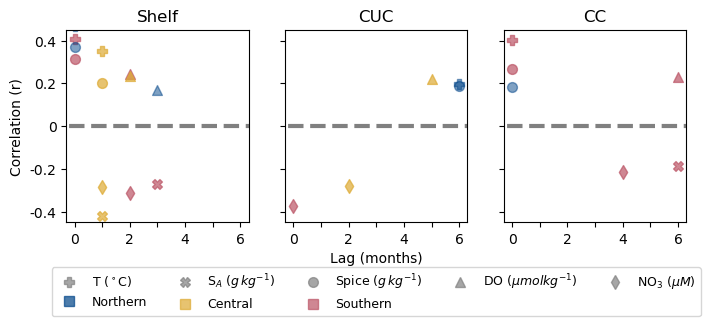

In [14]:
base_period = (1991, 2020)

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.45,0.45])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')



<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2401109/3822343614.py:97: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2401109/3822343614.py:97: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]


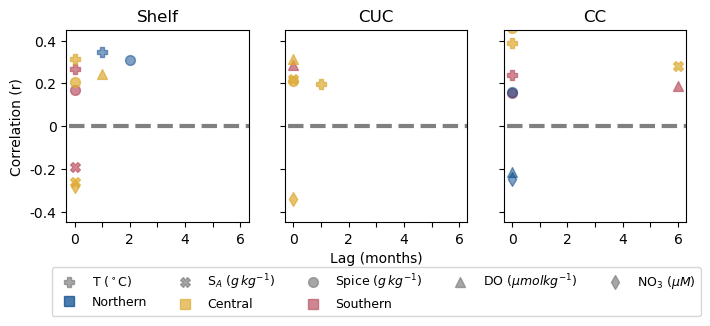

In [15]:
base_period = (1991, 2020)

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.45,0.45])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/pdo.png', bbox_inches='tight')


<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\,'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2401109/3826915904.py:97: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2401109/3826915904.py:97: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]


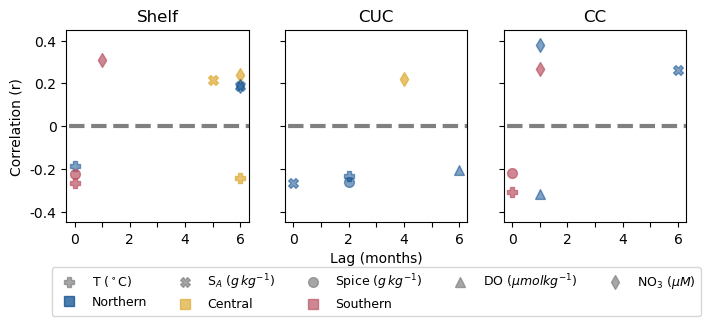

In [16]:
base_period = (1991, 2020)

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.45,0.45])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )

    best = _find_best_lag(anom_array[0], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(anom_array[1], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(anom_array[2], t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/npgo.png', bbox_inches='tight')


## Latitude Anomaly Plots
### Temperature

<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/214731252.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


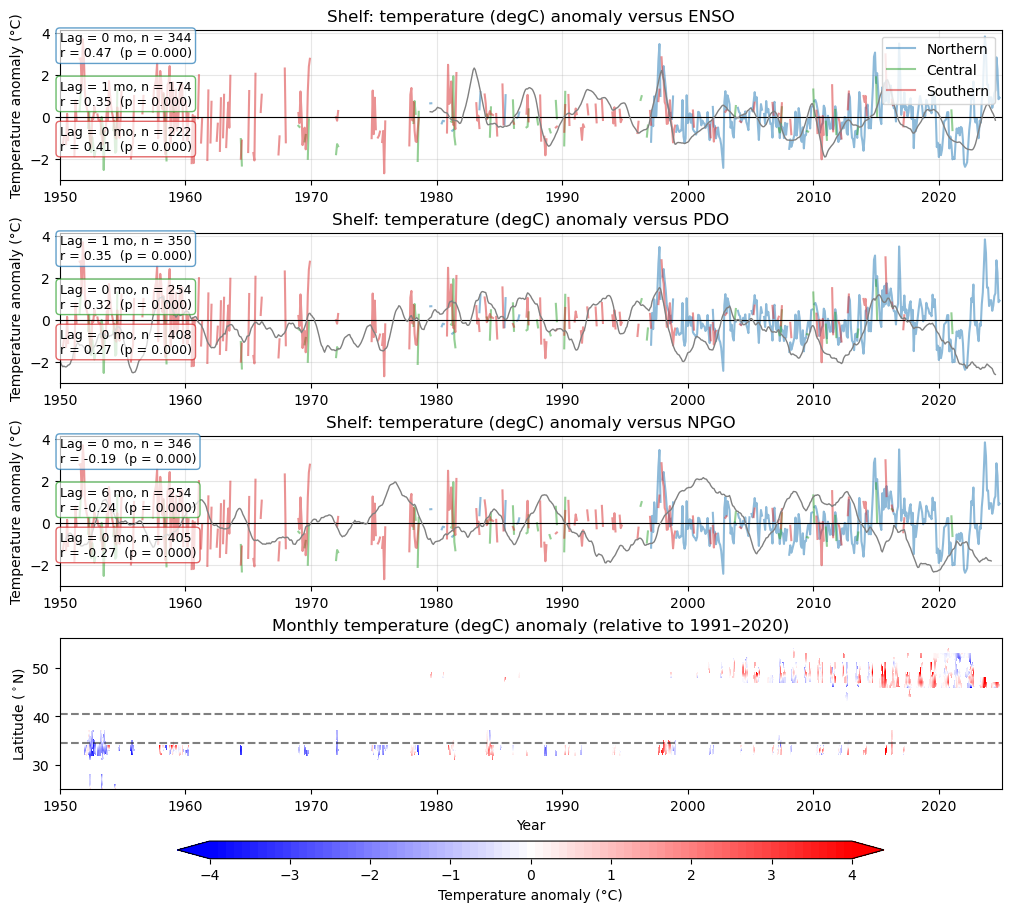

In [29]:
obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/1410231475.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


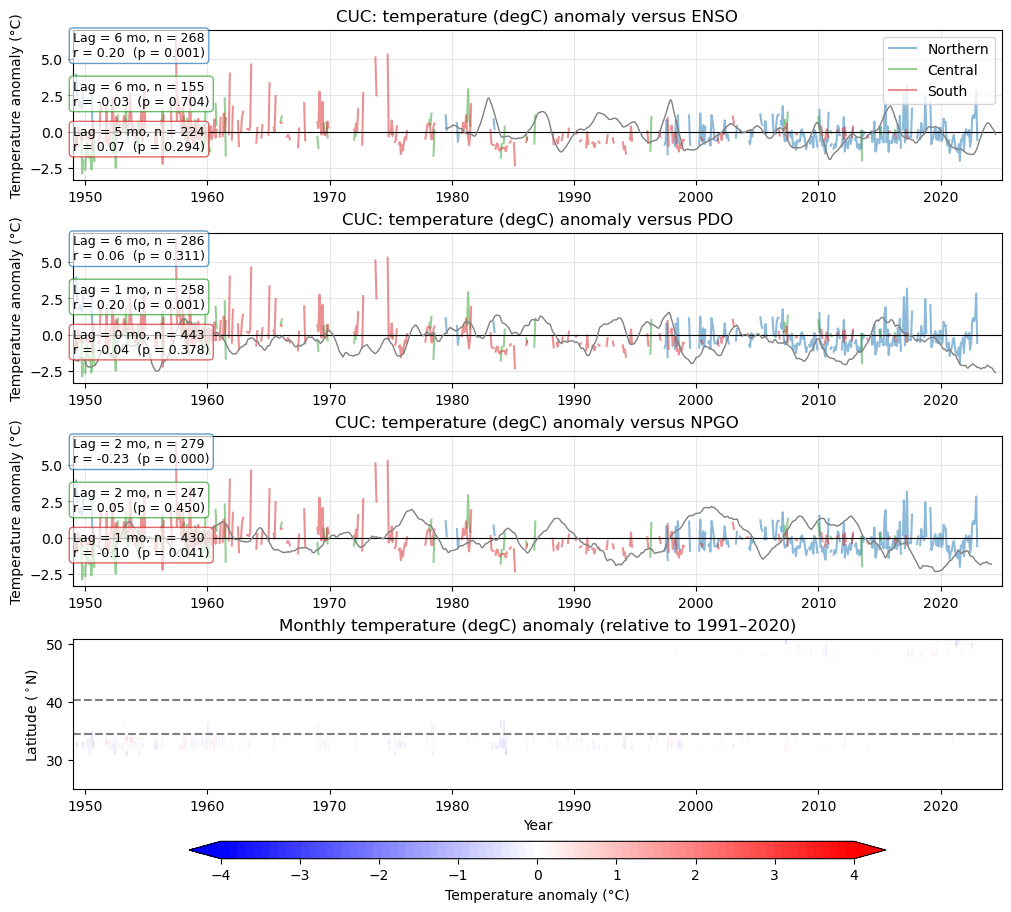

In [30]:
obs_used = obs_cuc.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='South')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/608231037.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


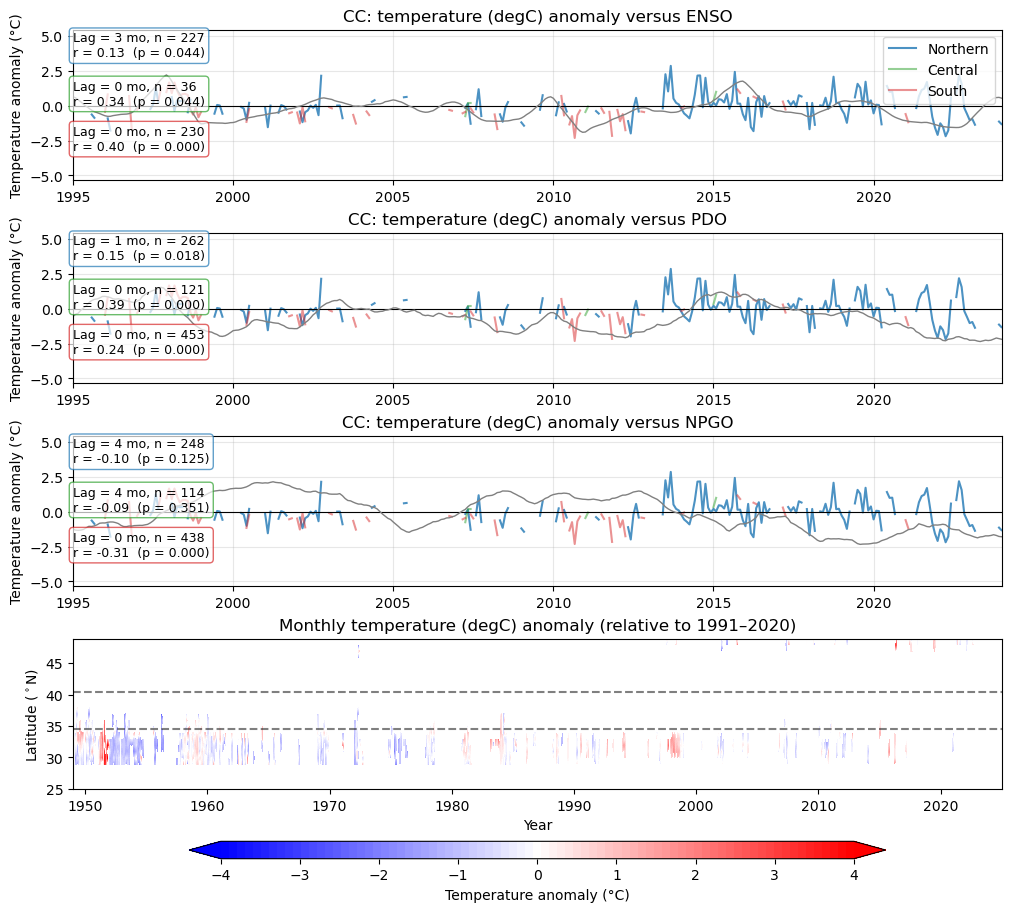

In [31]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.8, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='South')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')

ax[0].set_xlim([1995,2024])
ax[1].set_xlim([1995,2024])
ax[2].set_xlim([1995,2024])
plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NorthTAnom.png')


### Salinity

<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/2651067965.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


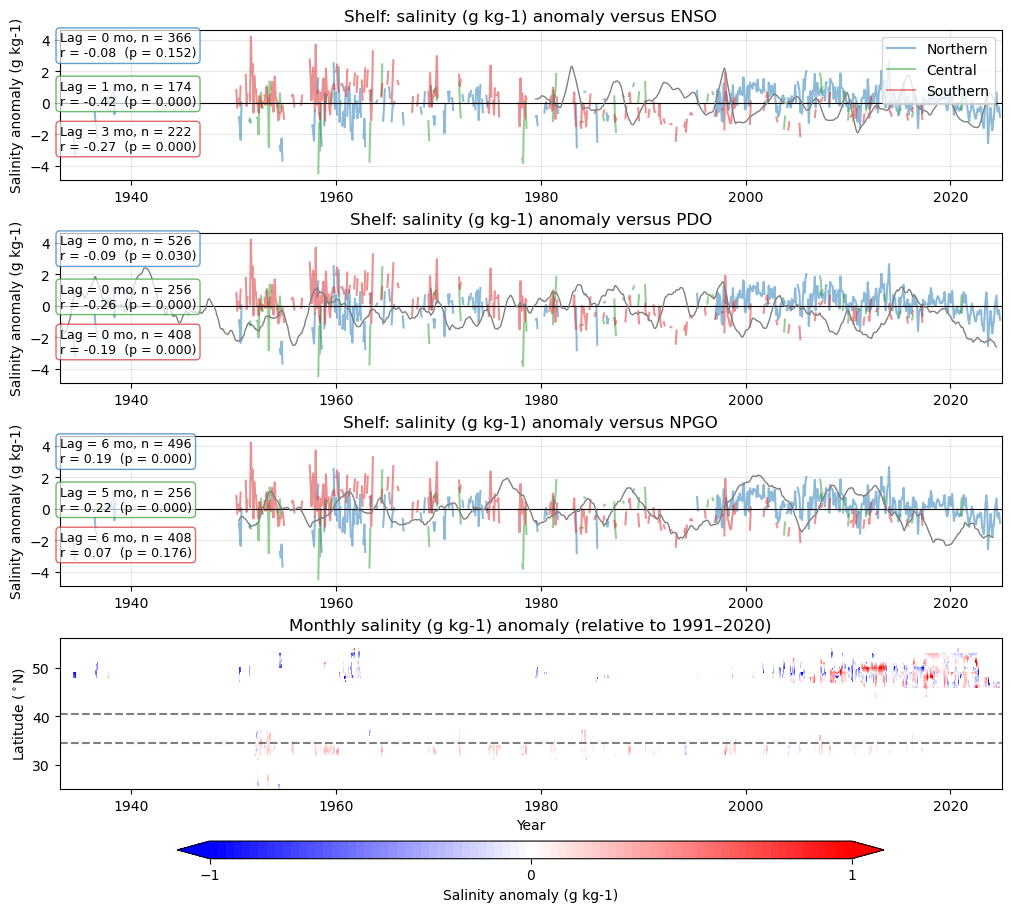

In [32]:
obs_used = obs_shelf.copy()
variable_str = 'salinity (g kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Salinity anomaly (g kg-1)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 1
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Salinity anomaly (g kg-1)')


<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/1880740691.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


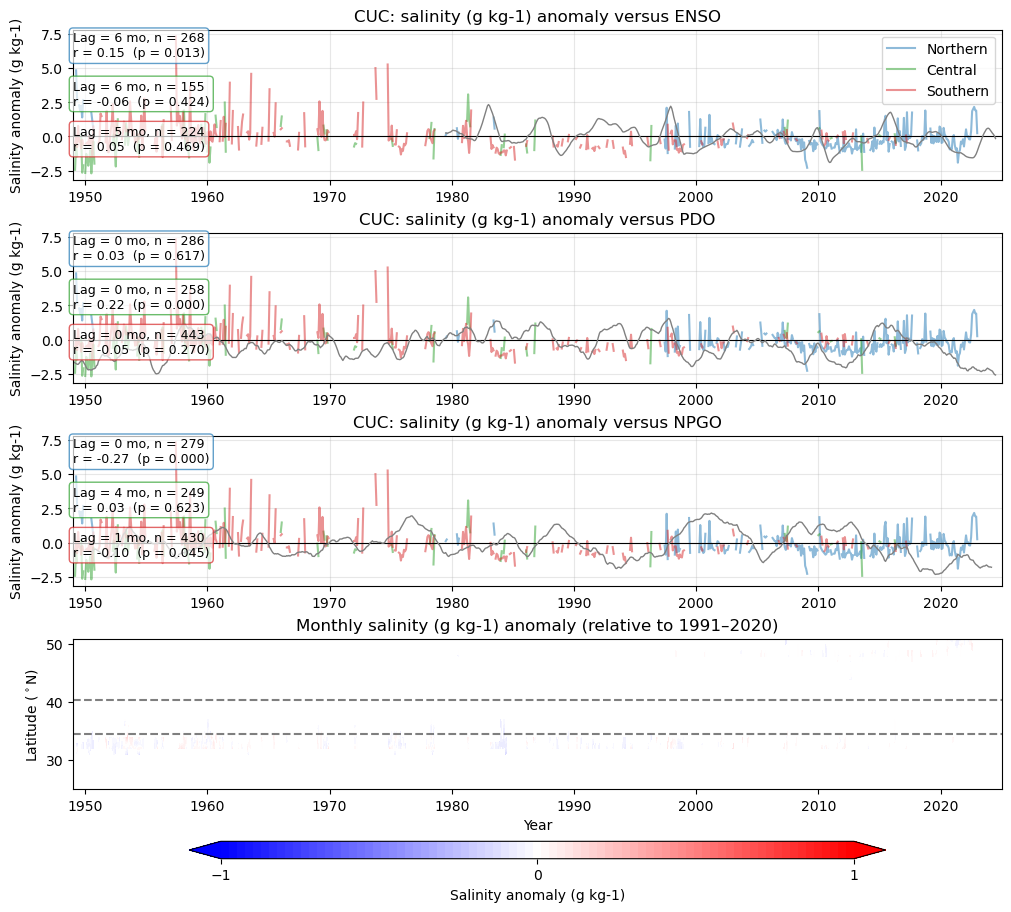

In [33]:
obs_used = obs_cuc.copy()
variable_str = 'salinity (g kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Salinity anomaly (g kg-1)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 1
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Salinity anomaly (g kg-1)')


<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/2498689230.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


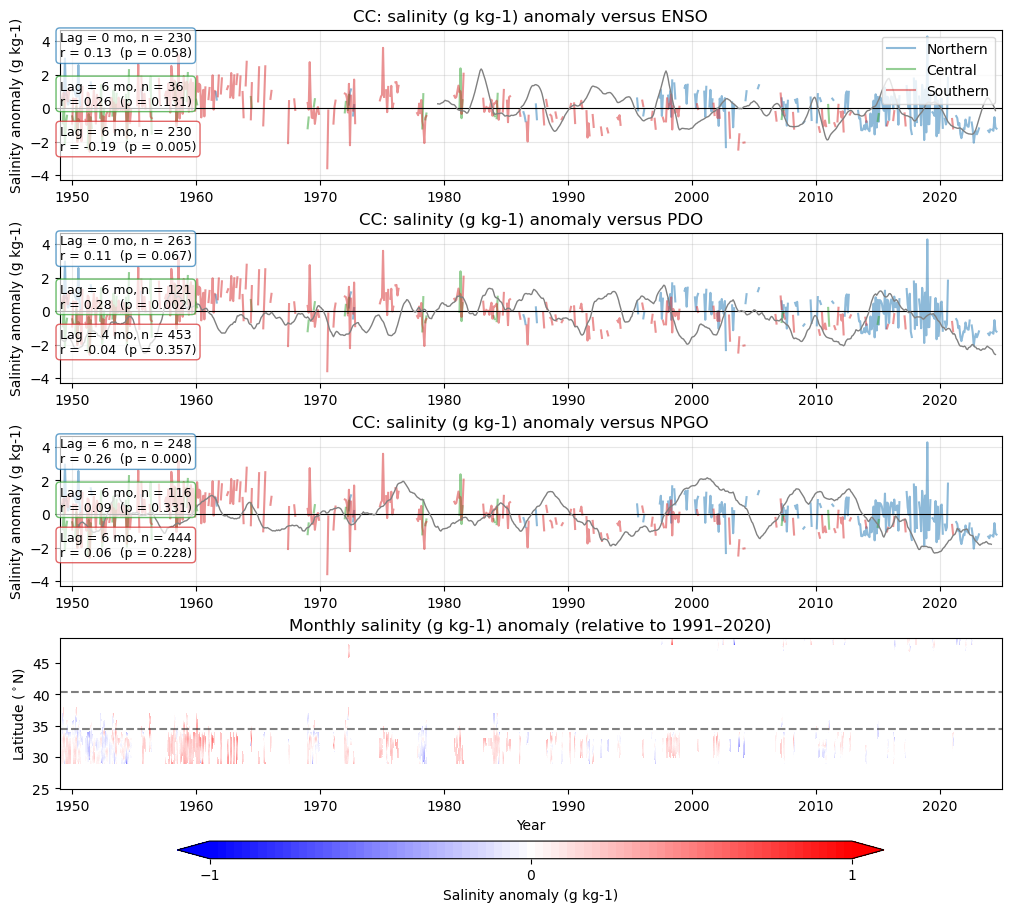

In [34]:
obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Salinity anomaly (g kg-1)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 1
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Salinity anomaly (g kg-1)')


### DO

<>:68: SyntaxWarning: invalid escape sequence '\c'
<>:68: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/303316958.py:68: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


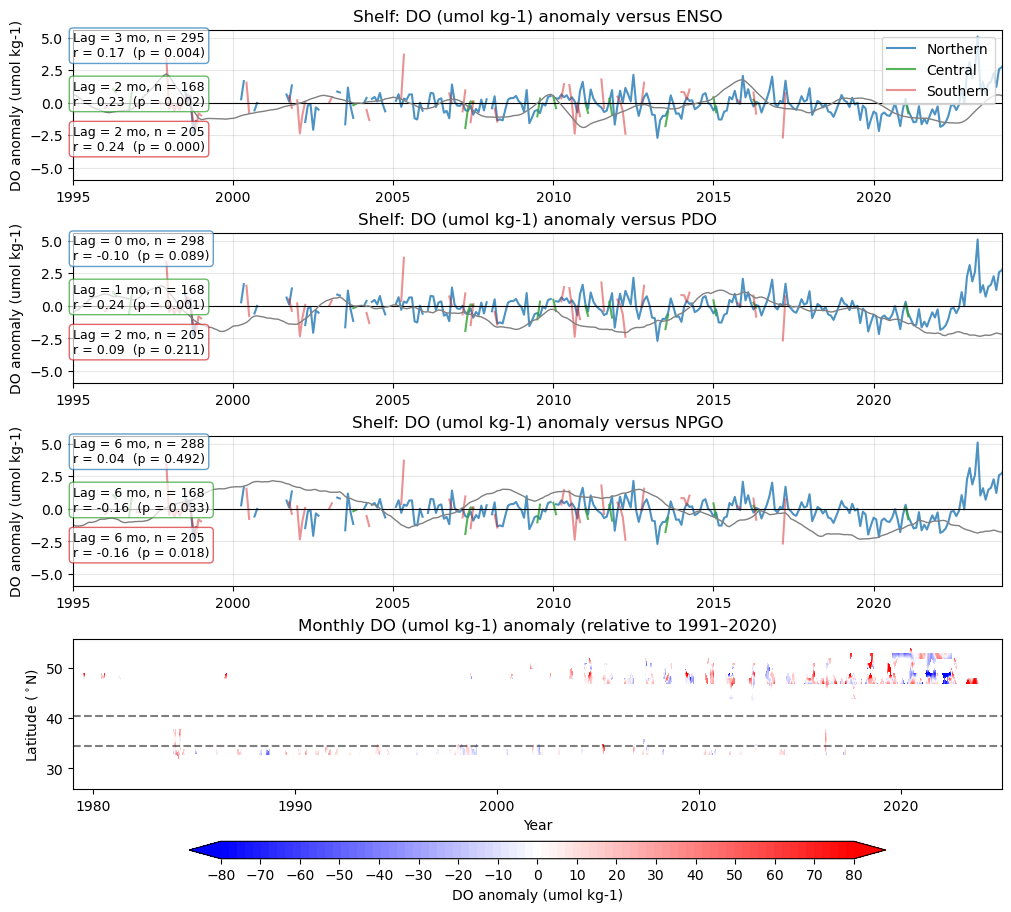

In [35]:
obs_used = obs_shelf.copy()
variable_str = 'DO (umol kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.8, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.8, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('DO anomaly (umol kg-1)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 80
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,10))
cbar.set_label('DO anomaly (umol kg-1)')


ax[0].set_xlim([1995,2024])
ax[1].set_xlim([1995,2024])
ax[2].set_xlim([1995,2024])
plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NorthShelfDOAnom.png')


<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/797036309.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


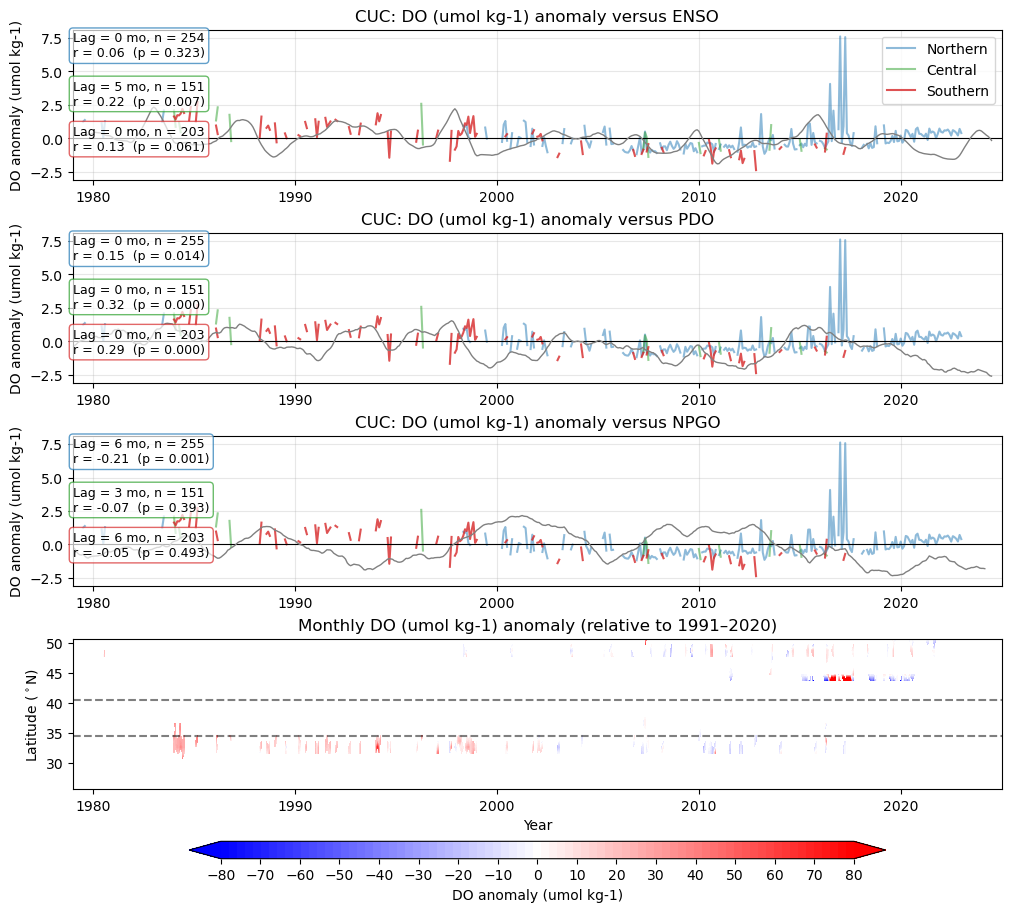

In [36]:
obs_used = obs_cuc.copy()
variable_str = 'DO (umol kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.8, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('DO anomaly (umol kg-1)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 80
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,10))
cbar.set_label('DO anomaly (umol kg-1)')

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/SouthSaCUCAnom.png')

<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/2564069372.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


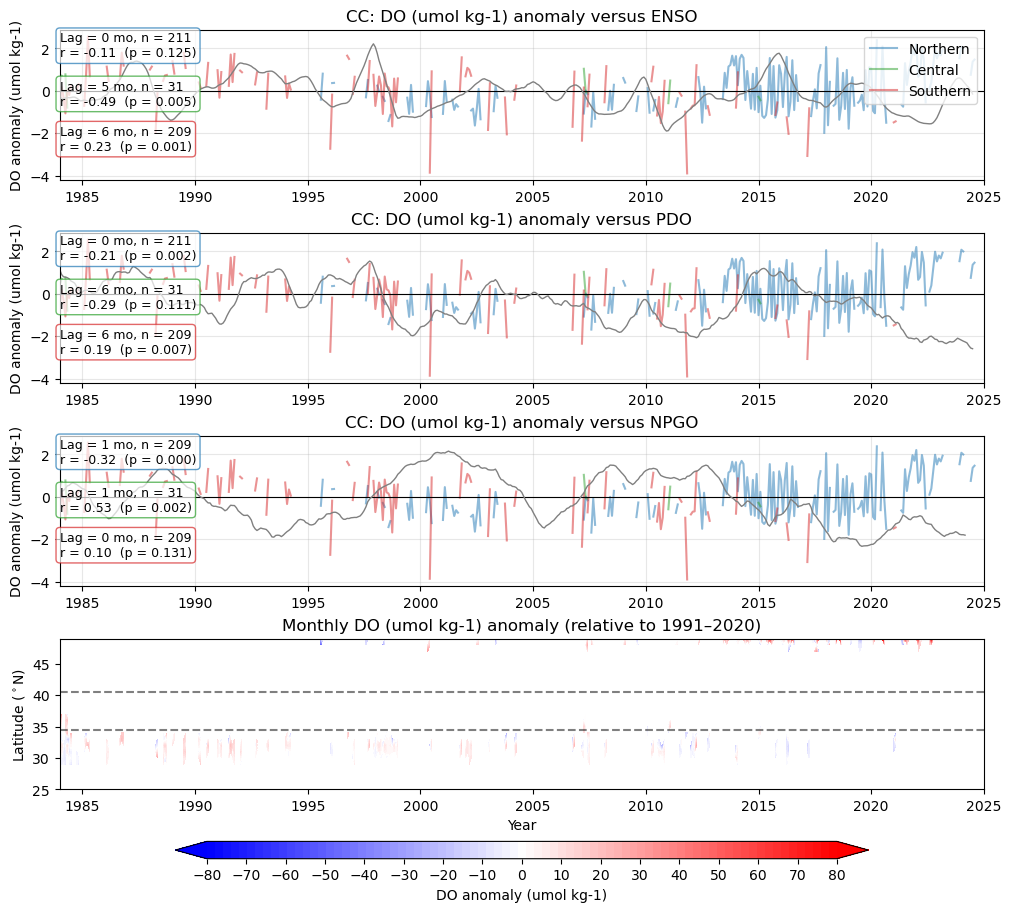

In [37]:
obs_used = obs_cc.copy()
variable_str = 'DO (umol kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('DO anomaly (umol kg-1)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 80
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,10))
cbar.set_label('DO anomaly (umol kg-1)')


### NO3

<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/3459686100.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


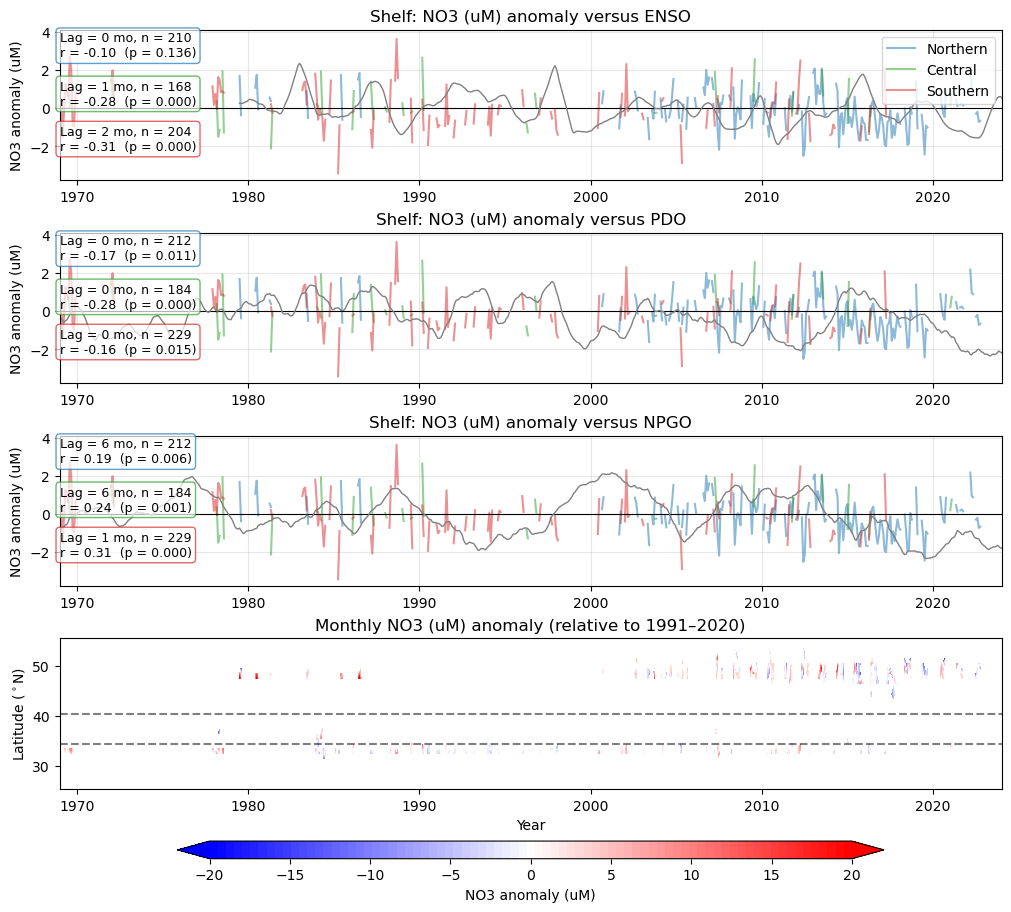

In [38]:
obs_used = obs_shelf.copy()
variable_str = 'NO3 (uM)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('NO3 anomaly (uM)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 20
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,5))
cbar.set_label('NO3 anomaly (uM)')


<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/3192274130.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


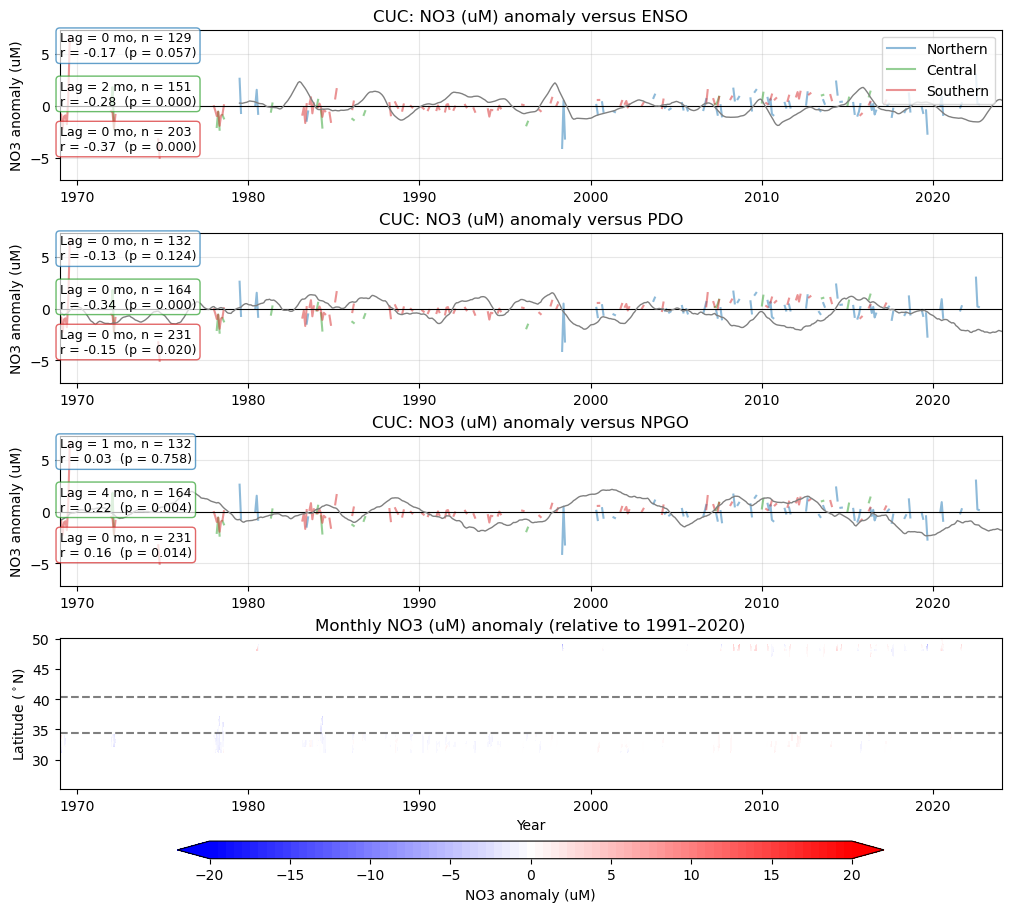

In [39]:
obs_used = obs_cuc.copy()
variable_str = 'NO3 (uM)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('NO3 anomaly (uM)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 20
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,5))
cbar.set_label('NO3 anomaly (uM)')


<>:69: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2401109/2458319284.py:69: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


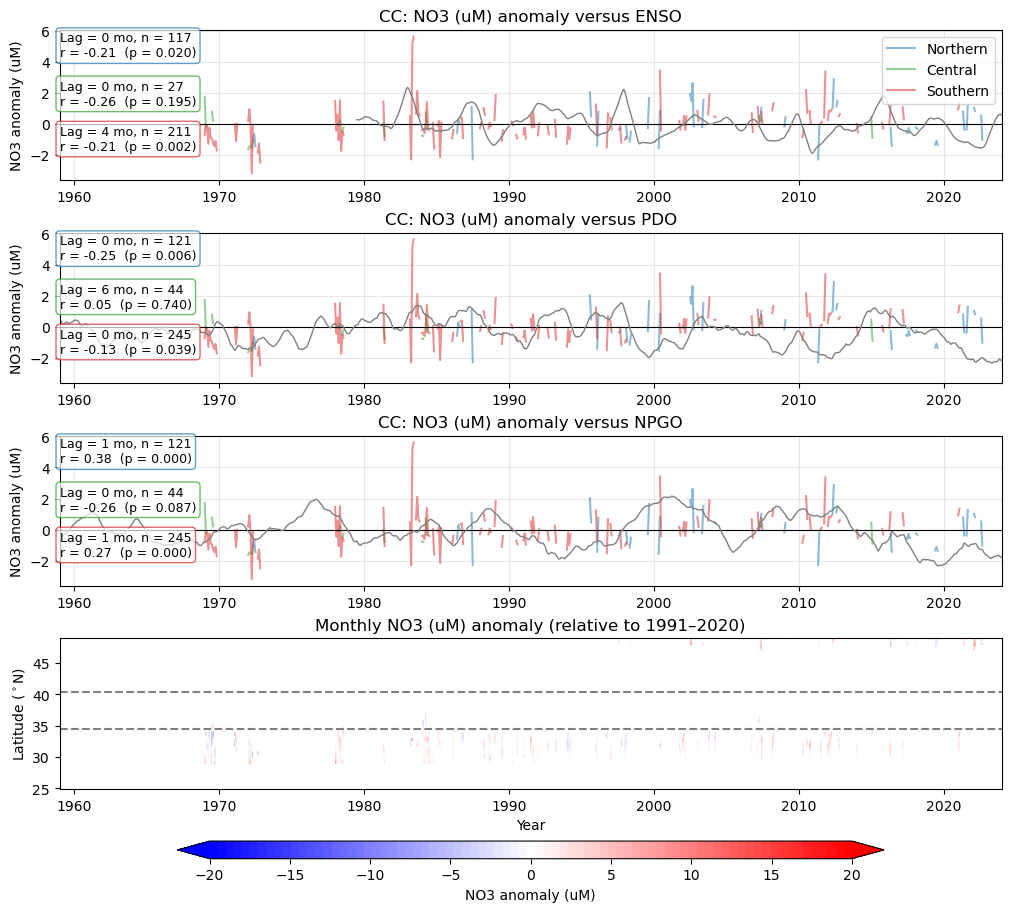

In [40]:
obs_used = obs_cc.copy()
variable_str = 'NO3 (uM)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('NO3 anomaly (uM)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_rm12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_rm12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_rm12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 20
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,5))
cbar.set_label('NO3 anomaly (uM)')
